<a href="https://colab.research.google.com/github/mohamedshouaib/iti/blob/main/Computer_Vision/Day01/siamesenetwork_faceverification3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!git clone https://github.com/mohamedshouaib/iti.git
!cd iti/Computer_Vision/Day01/Siamese

fatal: destination path 'iti' already exists and is not an empty directory.


In [61]:
import os
import cv2
import csv
import time
import random
import numpy as np
from google.colab.patches import cv2_imshow
from itertools import combinations
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
def load_dataset(base_path="iti/Computer_Vision/Day01/Siamese"):
    data = {'train': {}, 'test': {}}

    for person in os.listdir(base_path):
        person_path = os.path.join(base_path, person)
        if not os.path.isdir(person_path):
            continue

        for split in ['Train', 'Test']:
            split_path = os.path.join(person_path, split)
            if not os.path.exists(split_path):
                print(f"Missing {split} folder for {person}")
                continue

            # Find ANY CSV file
            csv_files = [f for f in os.listdir(split_path) if f.endswith('.csv')]
            if not csv_files:
                print(f"No CSV found in {split_path}")
                continue

            csv_path = os.path.join(split_path, csv_files[0])

            genuine = []
            forged = []

            with open(csv_path, 'r') as f:
                # Try different delimiters and column names
                try:
                    reader = csv.DictReader(f)
                    row = next(reader)  # Peek first row

                    # Detect column names
                    img_col = None
                    label_col = None

                    for col in row.keys():
                        col_lower = col.lower()
                        if 'image' in col_lower or 'name' in col_lower:
                            img_col = col
                        elif 'label' in col_lower or 'class' in col_lower:
                            label_col = col

                    if not img_col or not label_col:
                        raise ValueError("Couldn't detect required columns")

                    # Reset reader
                    f.seek(0)
                    next(reader)  # Skip header

                    for row in reader:
                        img_name = row[img_col].strip()
                        img_path = os.path.join(split_path, img_name)

                        if not os.path.exists(img_path):
                            print(f"Missing image: {img_path}")
                            continue

                        label = row[label_col].strip().lower()
                        if label == 'real' or label == 'genuine':
                            genuine.append(img_path)
                        elif label == 'forged' or label == 'fake':
                            forged.append(img_path)

                except Exception as e:
                    print(f"Error reading {csv_path}: {str(e)}")
                    continue

            if genuine or forged:  # Only add if we found data
                data[split.lower()][person] = {
                    'genuine': genuine,
                    'forged': forged
                }

    return data['train'], data['test']

# Test with debug info
print("Checking folder structure...")
base_path = "iti/Computer_Vision/Day01/Siamese"
print(f"Root contents: {os.listdir(base_path)}")
sample_person = os.listdir(base_path)[0]
print(f"Sample person contents: {os.listdir(os.path.join(base_path, sample_person))}")

train_data, test_data = load_dataset(base_path)

print("\nLoaded successfully!")
print(f"Persons in train: {list(train_data.keys())}")
print(f"Persons in test: {list(test_data.keys())}")

Checking folder structure...
Root contents: ['personE', 'personA', 'personB', 'personD', 'personC']
Sample person contents: ['Test', 'Train']

Loaded successfully!
Persons in train: ['personE', 'personA', 'personB', 'personD', 'personC']
Persons in test: ['personE', 'personA', 'personB', 'personD', 'personC']


In [63]:
def generate_triplets(data_dict, split='train'):
    triplets = []
    persons = list(data_dict[split].keys())

    for person in persons:
        genuine = data_dict[split][person]['genuine']
        forged = data_dict[split][person]['forged']

        # Generate all possible genuine pairs (anchor, positive)
        for i in range(len(genuine)):
            for j in range(i+1, len(genuine)):
                anchor = genuine[i]
                positive = genuine[j]

                # Pair with ALL forged signatures
                for neg in forged:
                    triplets.append((anchor, positive, neg))

                # # Also pair with genuine from DIFFERENT person (optional)
                # other_persons = [p for p in persons if p != person]
                # if other_persons:
                #     other_person = random.choice(other_persons)
                #     other_genuine = data_dict[split][other_person]['genuine']
                #     if other_genuine:
                #         triplets.append((anchor, positive, random.choice(other_genuine)))

    return triplets

In [64]:
# Generate triplets
train_triplets = generate_triplets({'train': train_data, 'test': test_data}, split='train')
test_triplets = generate_triplets({'train': train_data, 'test': test_data}, split='test')

In [65]:
# Check the actual dimensions of your images
sample_path = train_triplets[0][0]  # First anchor path
sample_img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
true_height, true_width = sample_img.shape
print(f"Actual image dimensions: {true_height}x{true_width}")

# Update your input shape
input_shape = (true_height, true_width, 1)

Actual image dimensions: 403x420


In [66]:
def load_triplet_images(triplet, img_size=(150, 150)):
    def load_image(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Failed to load image: {path}")
        img = cv2.resize(img, img_size)
        return img.astype(np.float32) / 255.0  # Normalize to [0,1]

    anchor = load_image(triplet[0])
    positive = load_image(triplet[1])
    negative = load_image(triplet[2])

    return anchor, positive, negative

In [67]:
# Usage Example
train_data, test_data = load_dataset("iti/Computer_Vision/Day01/Siamese")

In [68]:
def show_triplet(triplet):
    try:
        anchor, positive, negative = load_triplet_images(triplet)

        # Convert to 8-bit for display (if normalized to [0,1])
        if anchor.max() <= 1.0:
            anchor = (anchor * 255).astype(np.uint8)
            positive = (positive * 255).astype(np.uint8)
            negative = (negative * 255).astype(np.uint8)

        # Create a combined display image
        h, w = anchor.shape
        separator = np.ones((h, 5), dtype=np.uint8) * 255  # White separator
        combined = np.hstack([anchor, separator, positive, separator, negative])

        # Add labels
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(combined, 'Anchor', (5, 20), font, 0.5, 255, 1)
        cv2.putText(combined, 'Positive', (w+10, 20), font, 0.5, 255, 1)
        cv2.putText(combined, 'Negative', (2*w+15, 20), font, 0.5, 255, 1)

        # Display (use cv2_imshow in Colab, cv2.imshow otherwise)
        try:
            from google.colab.patches import cv2_imshow
            cv2_imshow(combined)
        except:
            cv2.imshow('Triplet', combined)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

    except Exception as e:
        print(f"Error displaying triplet: {e}")
        print(f"Triplet paths: {triplet}")

Generated 19000 train triplets
Generated 120 test triplets


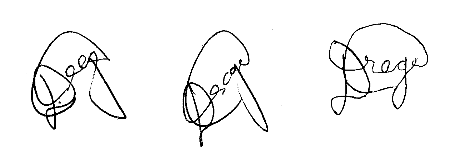

In [69]:
print(f"Generated {len(train_triplets)} train triplets")
print(f"Generated {len(test_triplets)} test triplets")
show_triplet(train_triplets[0])  # Display first training triplet

In [70]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),  # output: (32, 146, 146)
            nn.ReLU(),
            nn.MaxPool2d(2),                  # output: (32, 73, 73)

            nn.Conv2d(32, 64, kernel_size=5), # output: (64, 69, 69)
            nn.ReLU(),
            nn.MaxPool2d(2),                  # output: (64, 34, 34)
        )

        # Dynamically determine the output size after CNN layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 150, 150)  # (batch, channel, height, width)
            dummy_output = self.cnn(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).shape[1]
            print(f"[INFO] Flattened feature size: {self.flattened_size}")

        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

    def forward(self, anchor, positive, negative):
        out_anchor = self.forward_once(anchor)
        out_positive = self.forward_once(positive)
        out_negative = self.forward_once(negative)
        return out_anchor, out_positive, out_negative


In [71]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_pos = F.pairwise_distance(anchor, positive)
        distance_neg = F.pairwise_distance(anchor, negative)
        losses = F.relu(distance_pos - distance_neg + self.margin)
        return losses.mean()


In [72]:
class TripletDataset(Dataset):
    def __init__(self, triplets, img_size=(150, 150)):
        self.triplets = triplets
        self.img_size = img_size

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        a, p, n = self.triplets[idx]
        anchor, positive, negative = load_triplet_images((a, p, n), self.img_size)

        # Add channel dim
        anchor = torch.tensor(anchor).unsqueeze(0)
        positive = torch.tensor(positive).unsqueeze(0)
        negative = torch.tensor(negative).unsqueeze(0)

        return anchor, positive, negative

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
loss_fn = TripletLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

train_dataset = TripletDataset(train_triplets)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for anchor, positive, negative in loop:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        out_a, out_p, out_n = model(anchor, positive, negative)
        loss = loss_fn(out_a, out_p, out_n)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}")


[INFO] Flattened feature size: 73984


Epoch 1/5: 100%|██████████| 594/594 [03:05<00:00,  3.20it/s, loss=0]


Epoch 1, Loss: 3.2211607488417866


Epoch 2/5: 100%|██████████| 594/594 [03:05<00:00,  3.20it/s, loss=0]


Epoch 2, Loss: 5.710701977765119


Epoch 3/5:  12%|█▏        | 69/594 [00:21<02:47,  3.14it/s, loss=0]


KeyboardInterrupt: 

In [ ]:
def evaluate_model(model, test_triplets):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for triplet in test_triplets:
            a, p, n = load_triplet_images(triplet)
            a = torch.tensor(a).unsqueeze(0).unsqueeze(0).to(device)
            p = torch.tensor(p).unsqueeze(0).unsqueeze(0).to(device)
            n = torch.tensor(n).unsqueeze(0).unsqueeze(0).to(device)

            out_a, out_p = model.forward_once(a), model.forward_once(p)
            out_n = model.forward_once(n)

            d_ap = F.pairwise_distance(out_a, out_p)
            d_an = F.pairwise_distance(out_a, out_n)

            if d_ap.item() < d_an.item():
                correct += 1
            total += 1

    print(f"Accuracy on test set: {correct / total:.2f}")


In [ ]:
# Evaluate model on the test triplets
evaluate_model(model, test_triplets)

In [ ]:
torch.save(model.state_dict(), 'siamese_signature_model.pth')

# To load later
# model.load_state_dict(torch.load('siamese_signature_model.pth'))
# model.eval()


In [ ]:
def test_signature_pair(img_path1, img_path2, model, threshold=1.5):
    model.eval()
    img1, img2 = load_triplet_images((img_path1, img_path2, img_path2))[:2]  # ignore negative

    img1 = torch.tensor(img1).unsqueeze(0).unsqueeze(0).to(device)
    img2 = torch.tensor(img2).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        out1 = model.forward_once(img1)
        out2 = model.forward_once(img2)

    distance = F.pairwise_distance(out1, out2).item()
    print(f"Distance: {distance:.4f}")
    return distance < threshold  # True if similar


In [ ]:
# Example real vs. real (should return True if genuine match)
img_path1 = 'iti/Computer_Vision/Day01/Siamese/personA/Test/personA_29.png'
img_path2 = 'iti/Computer_Vision/Day01/Siamese/personA/Test/personA_13.png'

# Example real vs. forged (should return False if forged)
img_path3 = 'iti/Computer_Vision/Day01/Siamese/personA/Test/personA_29.png'
img_path4 = 'iti/Computer_Vision/Day01/Siamese/personA/Test/personA_33.png'

# Test genuine match
is_match = test_signature_pair(img_path1, img_path2, model)
print("Match (real vs. real):", is_match)

# Test forged case
is_forged = test_signature_pair(img_path3, img_path4, model)
print("Match (real vs. forged):", is_forged)